First, we will generate a very simple dataset for the demonstration. The inputs are vectors of 10 binaries, and the outputs are just single binaries. The inputs could be represented by integers from 0 to 1023 ($=2^{10}-1$). The 1024 possible inputs are divided into 16 groups (each group has 64 numbers), and each integer input $n\in[0,1023]$ belongs to group $i$ if $x\equiv i \pmod{16}$, where $i \in [0,15]$. Each group $i$ is then associated with a random binary number (output).

In [1]:
import numpy as np
from random import randint, seed
import tensorflow as tf

In [3]:
n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

Let us compute theoretical mutual information between $X$ and $Y$
\begin{align}
I(X;Y) = \sum_{x\in X, y\in Y}P(x|y)P(y)\log\Big(\frac{P(x|y)P(y)}{P(x)P(y)}\Big) 
= \sum_{x\in X}\Big[P(x|y=0)P(y=0)\log\Big(\frac{P(x|y=0)}{P(x)}\Big) + P(x|y=1)P(y=1)\log\Big(\frac{P(x|y=1)}{P(x)}\Big)\Big]
= 1024 \Big[ \frac{1}{1024}\log\Big(\frac{1/1024}{0.5/1024}\Big) + 0\Big] 
= 0.693.
\end{align}

In [4]:
def mlp(x, n_neurons, activation):
    def output(tensor, n_outputs):
        size = tensor.get_shape().as_list()[1]
        weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
        bias = tf.Variable(tf.zeros([n_outputs]))
        tensor = tf.matmul(tensor, weight)
        bias = tf.nn.bias_add(tensor, bias)
        return tensor
    def fully_conn(tensor, n_outputs, name):
        size = tensor.get_shape().as_list()[1]
        weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
        bias = tf.Variable(tf.zeros([n_outputs]))
        tensor = tf.matmul(tensor, weight)
        bias = tf.nn.bias_add(tensor, bias)
        tensor = activation(tensor, name=name)
        return tensor
    hidden = x
    for n in range(len(n_neurons)):
        hidden = fully_conn(hidden, n_neurons[n], 'hidden%s' % (n+1))
    y = output(hidden, 2)
    return y

In [5]:
def build_network(hidden_layer_neurons, activation):
    global x, y, logits, cost, optimizer, accuracy
    
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 10), name='x')
    y = tf.placeholder(tf.float32, (None, 2), name='y')
    logits = mlp(x, hidden_layer_neurons, activation)
    logits = tf.identity(logits, name='logits')
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
def print_out_summary(sess, epoch):
    acc, loss = sess.run([accuracy, cost], feed_dict={x: x_test, y: y_test})
    print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f}'.format(epoch, acc, loss))

build_network([12, 10 , 8 , 6, 4], tf.tanh) # 3 hidden layers with 8, 6 and 4 neurons respectively

In [7]:
from collections import Counter

def calc_mutual_information(hidden):
    n_neurons = hidden.shape[1]
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
        
    mi_xt = 0
    for i in pdf_xt:
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    mi_ty = 0
    for i in pdf_yt:
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        mi_ty += p_yt * np.log(p_yt / p_t / p_y)
            
    return mi_xt, mi_ty

def get_mutual_information(hiddens):
    mi_xt_list = []; mi_ty_list = []
    for hidden in hiddens:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [8]:
def get_hidden_layers(names):
    hidden_layers = []
    for name in names:
        hidden_layers.append(tf.get_default_graph().get_tensor_by_name("%s:0" % name))
    return hidden_layers

# train the neural network and obtain mutual information
def train_with_mi(n_epochs, n_hidden_layers):
    mi_xt_all = []; mi_ty_all = []; epochs = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # initialization
    
        hidden_layer_names = ['hidden%s' % i for i in range(1,n_hidden_layers+1)]
        for epoch in range(n_epochs):
            _, hidden_layers = sess.run([optimizer,
                                         get_hidden_layers(hidden_layer_names)],
                                        feed_dict={x: x_train, y: y_train})
                        
            if epoch % 100 == 0: print_out_summary(sess, epoch)
                
            if epoch % 20 == 0:
                mi_xt, mi_ty = get_mutual_information(hidden_layers)
                mi_xt_all.append(mi_xt)
                mi_ty_all.append(mi_ty)
                epochs.append(epoch)
    
    return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs)

n_epochs = 2000
n_hidden_layers = 3
#mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

## Visualization

Below is a movie showing the evolution of the hidden layers with the training epochs in the information plane. We can clearly see two distinct optimization phases in the information plane, as discussed in the paper. During the first *empirical error minimization* (ERM) phase (until around epoch 1500), the information on the outputs $I_Y$ increases quickly, and then during the second *representation compression* phase (from around epoch 1500 onwards), the information on the inputs $I_X$ decreases. The evolution is not as smooth as shown in the paper, because it is the result of only one network, instead of average of multiple networks. 

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

0it [00:00, ?it/s]

Epoch    0:  Testing accuracy 0.5217 - Testing loss 0.8920
Epoch  100:  Testing accuracy 0.6472 - Testing loss 0.6639
Epoch  200:  Testing accuracy 0.6791 - Testing loss 0.5855
Epoch  300:  Testing accuracy 0.7075 - Testing loss 0.5175
Epoch  400:  Testing accuracy 0.7301 - Testing loss 0.4456
Epoch  500:  Testing accuracy 0.8448 - Testing loss 0.3494
Epoch  600:  Testing accuracy 0.9419 - Testing loss 0.2202
Epoch  700:  Testing accuracy 0.9750 - Testing loss 0.1299
Epoch  800:  Testing accuracy 0.9952 - Testing loss 0.0631
Epoch  900:  Testing accuracy 1.0000 - Testing loss 0.0357
Epoch 1000:  Testing accuracy 1.0000 - Testing loss 0.0226
Epoch 1100:  Testing accuracy 1.0000 - Testing loss 0.0161
Epoch 1200:  Testing accuracy 1.0000 - Testing loss 0.0124
Epoch 1300:  Testing accuracy 1.0000 - Testing loss 0.0102
Epoch 1400:  Testing accuracy 1.0000 - Testing loss 0.0086
Epoch 1500:  Testing accuracy 1.0000 - Testing loss 0.0075
Epoch 1600:  Testing accuracy 1.0000 - Testing loss 0.00

1it [18:56, 1136.30s/it]

Epoch    0:  Testing accuracy 0.4846 - Testing loss 0.7952
Epoch  100:  Testing accuracy 0.5079 - Testing loss 0.6900
Epoch  200:  Testing accuracy 0.5448 - Testing loss 0.6769
Epoch  300:  Testing accuracy 0.5599 - Testing loss 0.6688
Epoch  400:  Testing accuracy 0.5918 - Testing loss 0.6605
Epoch  500:  Testing accuracy 0.5964 - Testing loss 0.6510
Epoch  600:  Testing accuracy 0.6120 - Testing loss 0.6393
Epoch  700:  Testing accuracy 0.6329 - Testing loss 0.6246
Epoch  800:  Testing accuracy 0.6592 - Testing loss 0.6054
Epoch  900:  Testing accuracy 0.6947 - Testing loss 0.5762
Epoch 1000:  Testing accuracy 0.7245 - Testing loss 0.5375
Epoch 1100:  Testing accuracy 0.7446 - Testing loss 0.5037
Epoch 1200:  Testing accuracy 0.7744 - Testing loss 0.4717
Epoch 1300:  Testing accuracy 0.7913 - Testing loss 0.4127
Epoch 1400:  Testing accuracy 0.8199 - Testing loss 0.3318
Epoch 1500:  Testing accuracy 0.8360 - Testing loss 0.2761
Epoch 1600:  Testing accuracy 0.8526 - Testing loss 0.24

2it [48:56, 1468.02s/it]
0it [00:00, ?it/s]

Epoch    0:  Testing accuracy 0.4930 - Testing loss 1.0719
Epoch  100:  Testing accuracy 0.5066 - Testing loss 0.6911
Epoch  200:  Testing accuracy 0.5092 - Testing loss 0.6894
Epoch  300:  Testing accuracy 0.5131 - Testing loss 0.6877
Epoch  400:  Testing accuracy 0.5140 - Testing loss 0.6861
Epoch  500:  Testing accuracy 0.5143 - Testing loss 0.6844
Epoch  600:  Testing accuracy 0.5126 - Testing loss 0.6827
Epoch  700:  Testing accuracy 0.5126 - Testing loss 0.6810
Epoch  800:  Testing accuracy 0.5149 - Testing loss 0.6794
Epoch  900:  Testing accuracy 0.5161 - Testing loss 0.6778
Epoch 1000:  Testing accuracy 0.5168 - Testing loss 0.6764
Epoch 1100:  Testing accuracy 0.5168 - Testing loss 0.6752
Epoch 1200:  Testing accuracy 0.5193 - Testing loss 0.6738
Epoch 1300:  Testing accuracy 0.5211 - Testing loss 0.6725
Epoch 1400:  Testing accuracy 0.5222 - Testing loss 0.6715
Epoch 1500:  Testing accuracy 0.5222 - Testing loss 0.6706
Epoch 1600:  Testing accuracy 0.5222 - Testing loss 0.66

1it [18:19, 1099.70s/it]

Epoch    0:  Testing accuracy 0.4437 - Testing loss 0.7407
Epoch  100:  Testing accuracy 0.5146 - Testing loss 0.6928
Epoch  200:  Testing accuracy 0.5198 - Testing loss 0.6921
Epoch  300:  Testing accuracy 0.5193 - Testing loss 0.6915
Epoch  400:  Testing accuracy 0.5190 - Testing loss 0.6909
Epoch  500:  Testing accuracy 0.5230 - Testing loss 0.6901
Epoch  600:  Testing accuracy 0.5264 - Testing loss 0.6892
Epoch  700:  Testing accuracy 0.5233 - Testing loss 0.6881
Epoch  800:  Testing accuracy 0.5308 - Testing loss 0.6872
Epoch  900:  Testing accuracy 0.5323 - Testing loss 0.6859
Epoch 1000:  Testing accuracy 0.5306 - Testing loss 0.6844
Epoch 1100:  Testing accuracy 0.5313 - Testing loss 0.6821
Epoch 1200:  Testing accuracy 0.5307 - Testing loss 0.6796
Epoch 1300:  Testing accuracy 0.5298 - Testing loss 0.6767
Epoch 1400:  Testing accuracy 0.5392 - Testing loss 0.6738
Epoch 1500:  Testing accuracy 0.5367 - Testing loss 0.6708
Epoch 1600:  Testing accuracy 0.5467 - Testing loss 0.66

2it [50:12, 1506.47s/it]


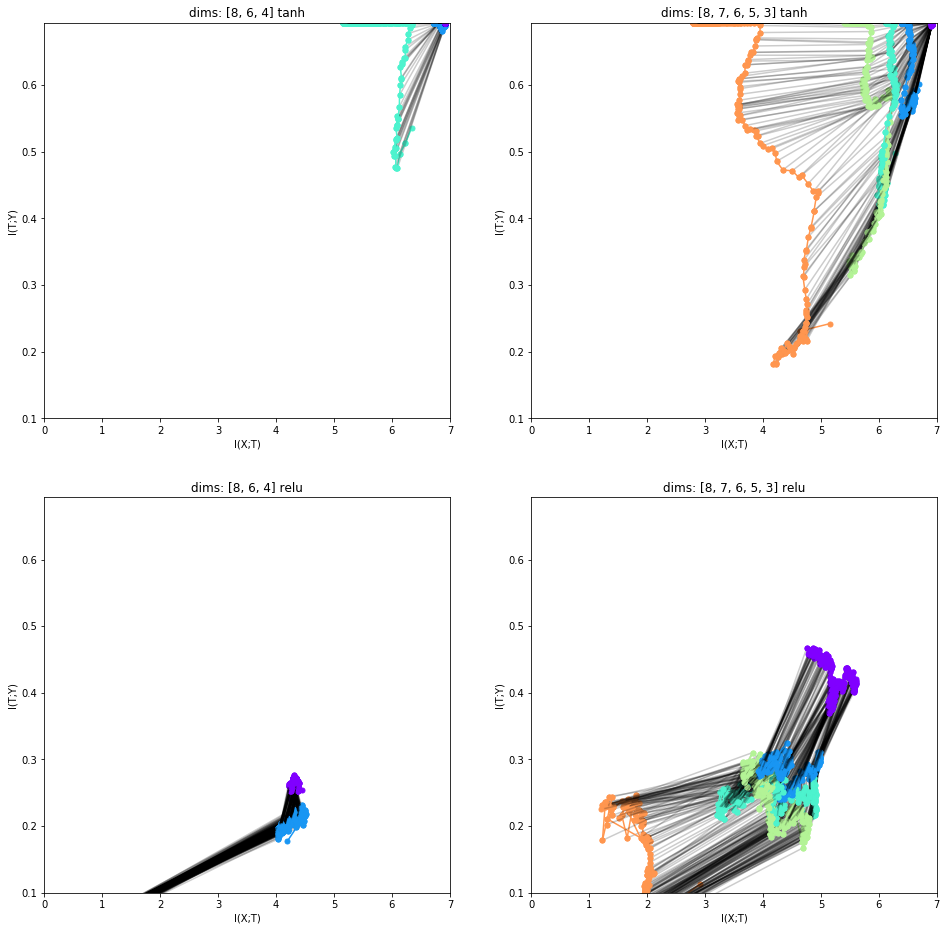

In [9]:
from tqdm import tqdm 
cmap = plt.cm.get_cmap('rainbow')

def animate(i):
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,16))
lays = [[8,6,4], [8,7,6,5,3]]
n_epochs = 4500
axes = list(axes[0]) + list(axes[1])

for activation in [tf.tanh, tf.nn.relu]:
    for i, hidden_layers in tqdm(enumerate(lays[:])):
        build_network(hidden_layers, activation)
        n_hidden_layers = len(hidden_layers)
        mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)
        ax = axes[i]
        if activation == tf.nn.relu: ax = axes[i + 2]
        ax.set_xlim((0,7))
        ax.set_ylim((0.1,np.log(2)))
        ax.set_xlabel('I(X;T)')
        ax.set_ylabel('I(T;Y)')
        title = ax.set_title('')
        title.set_text('dims: ' + str(hidden_layers) + ' tanh')
        if activation == tf.nn.relu: title.set_text('dims: ' + str(hidden_layers) + ' relu')
        for q in range(1, len(mi_xt_all) - 1): animate(q)

In [11]:
tf.set_random_seed(12345)
build_network([8,7,6,5,3], tf.nn.relu)
n_epochs = 4500
n_hidden_layers = 5
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)


Epoch    0:  Testing accuracy 0.5097 - Testing loss 0.7150
Epoch  100:  Testing accuracy 0.5174 - Testing loss 0.6912
Epoch  200:  Testing accuracy 0.5188 - Testing loss 0.6789
Epoch  300:  Testing accuracy 0.5485 - Testing loss 0.6599
Epoch  400:  Testing accuracy 0.5925 - Testing loss 0.6242
Epoch  500:  Testing accuracy 0.6619 - Testing loss 0.5760
Epoch  600:  Testing accuracy 0.7034 - Testing loss 0.5505
Epoch  700:  Testing accuracy 0.7142 - Testing loss 0.5405
Epoch  800:  Testing accuracy 0.7106 - Testing loss 0.5357
Epoch  900:  Testing accuracy 0.7257 - Testing loss 0.5331
Epoch 1000:  Testing accuracy 0.7394 - Testing loss 0.5304
Epoch 1100:  Testing accuracy 0.7477 - Testing loss 0.5281
Epoch 1200:  Testing accuracy 0.7378 - Testing loss 0.5263
Epoch 1300:  Testing accuracy 0.7450 - Testing loss 0.5228
Epoch 1400:  Testing accuracy 0.7600 - Testing loss 0.5152
Epoch 1500:  Testing accuracy 0.7690 - Testing loss 0.5087
Epoch 1600:  Testing accuracy 0.7088 - Testing loss 0.50

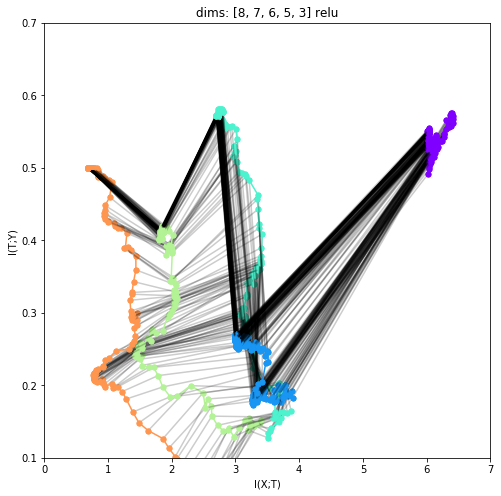

In [15]:
cmap = plt.cm.get_cmap('rainbow')
def animate(i):
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
title.set_text('dims: ' + str([8,7,6,5,3]) + ' relu')
for q in range(1, len(mi_xt_all) - 1): animate(q)


In [17]:
build_network([8,7,6,5,3], tf.tanh)
n_epochs = 3000
n_hidden_layers = 5
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)


Epoch    0:  Testing accuracy 0.4466 - Testing loss 0.8371
Epoch  100:  Testing accuracy 0.5445 - Testing loss 0.6935
Epoch  200:  Testing accuracy 0.5717 - Testing loss 0.6853
Epoch  300:  Testing accuracy 0.5908 - Testing loss 0.6785
Epoch  400:  Testing accuracy 0.5996 - Testing loss 0.6708
Epoch  500:  Testing accuracy 0.6131 - Testing loss 0.6612
Epoch  600:  Testing accuracy 0.6222 - Testing loss 0.6482
Epoch  700:  Testing accuracy 0.6395 - Testing loss 0.6314
Epoch  800:  Testing accuracy 0.6650 - Testing loss 0.6044
Epoch  900:  Testing accuracy 0.7151 - Testing loss 0.5563
Epoch 1000:  Testing accuracy 0.7564 - Testing loss 0.4886
Epoch 1100:  Testing accuracy 0.8172 - Testing loss 0.3970
Epoch 1200:  Testing accuracy 0.8711 - Testing loss 0.3111
Epoch 1300:  Testing accuracy 0.9192 - Testing loss 0.2400
Epoch 1400:  Testing accuracy 0.9486 - Testing loss 0.1893
Epoch 1500:  Testing accuracy 0.9533 - Testing loss 0.1597
Epoch 1600:  Testing accuracy 0.9641 - Testing loss 0.13

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((2,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)
HTML(anim.to_html5_video())
